In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append("../..")
from models import RNN

import sklearn.metrics as metrics
from scipy.optimize import minimize
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras import backend as K
import tensorflow.keras.utils as kutils

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

   accuracy  val_accuracy
0  0.601832           0.6
1  0.543642           0.6
2  0.598060           0.6
3  0.601832           0.6
4  0.601832           0.6


Text(0, 0.5, 'Accuracy')

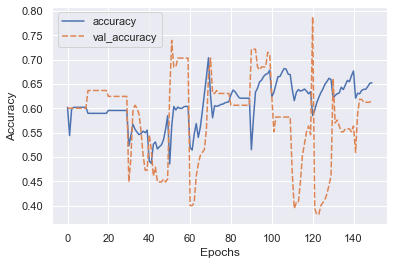

In [2]:
n_epochs = 150
n_models = 15
n_steps = 48
model_prefix = f"RNN-snapshot-{n_steps}-{n_epochs}"

raw_data = pd.read_csv(f'{model_prefix}.csv')
raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
print(raw_data.head())

sns.set_theme()
sns.lineplot(data=raw_data)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Ensemble snapshots and produce results 'over_time'


In [6]:
elec = pd.read_csv('../../data/electricity-normalized.csv')
X = elec.values[:,0:8].astype(np.float)
y = elec.values[:,8]
enc = LabelBinarizer()
y = enc.fit_transform(y.reshape(-1, 1))

dataset_test = timeseries_dataset_from_array(X, y, sequence_length=n_steps, batch_size=int(0.3 * len(X)), start_index=int(0.7 * len(X)))
X_test, y_test = list(dataset_test)[0]

X_test = X_test.numpy()
y_test = y_test.numpy()

NUM_TESTS=25
nb_classes=2

In [7]:
snapshot_model = RNN.create_rnn_model(n_timesteps=n_steps, n_features=8, n_outputs=1)
snapshot_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

file_list =[f'./{model_prefix}/{model_prefix}-{j}-1.h5' for j in range(n_models)]

preds = []
for fn in file_list:
    snapshot_model.load_weights(fn)
    yPreds = snapshot_model.predict(X_test)
    preds.append(yPreds)

    print("Obtained predictions from model with weights = %s" % (fn))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48)                10944     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 49        
Total params: 10,993
Trainable params: 10,993
Non-trainable params: 0
_________________________________________________________________
Obtained predictions from model with weights = ./RNN-snapshot-48-150/RNN-snapshot-48-150-0-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-48-150/RNN-snapshot-48-150-1-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-48-150/RNN-snapshot-48-150-2-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-48-150/RNN-snapshot-48-150-3-1.h5
Obtained predictions from model with weights = ./RNN-snapshot-48-150/RNN-snapshot-48-150-4-1.h5
Obtained predictions from model 

In [8]:
def calculate_weighted_accuracy(prediction_weights):
    weighted_predictions = np.zeros((X_test.shape[0], nb_classes), dtype='float32')
    for weight, prediction in zip(prediction_weights, preds):
        weighted_predictions += weight * prediction
    yPred = np.argmax(weighted_predictions, axis=1)
    yTrue = testY
    accuracy = metrics.accuracy_score(yTrue, yPred) * 100
    error = 100 - accuracy
    print("Accuracy: ", accuracy)
    print("Error: ", error)

In [23]:
# Create the loss metric
def log_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = np.zeros((X_test.shape[0], nb_classes), dtype='float32')

    for weight, prediction in zip(weights, preds):
        final_prediction += weight * prediction

    return log_loss(y_test, final_prediction)

In [24]:
def get_accuracy_for_n_snapshots(n_snapshots):
    best_acc = 0.0
    best_weights = None

    # Parameters for optimization
    constraints = ({'type': 'eq', 'fun':lambda w: 1 - sum(w)})
    bounds = [(0, 1)] * n_snapshots

    # Check for NUM_TESTS times
    for iteration in range(NUM_TESTS):
        # Random initialization of weights
        prediction_weights = np.random.random(n_snapshots)
        
        # Minimise the loss 
        result = minimize(log_loss_func, prediction_weights, method='SLSQP', bounds=bounds, constraints=constraints)
        print('Best Ensemble Weights: {weights}'.format(weights=result['x']))
        
        weights = result['x']
        weighted_predictions = np.zeros((X_test.shape[0], nb_classes), dtype='float32')
        
        # Calculate weighted predictions
        for weight, prediction in zip(weights, preds[:n_snapshots]):
            weighted_predictions += weight * prediction

        yPred = np.argmax(weighted_predictions, axis=1)
        yTrue = y_test

        # Calculate weight prediction accuracy
        accuracy = metrics.accuracy_score(yTrue, yPred) * 100
        error = 100 - accuracy
        print("Iteration %d: Accuracy : " % (iteration + 1), accuracy)
        print("Iteration %d: Error : " % (iteration + 1), error)
        
        # Save current best weights 
        if accuracy > best_acc:
            best_acc = accuracy
            best_weights = weights
            
        print()

        return accuracy

In [25]:
results = []
for i in range(1, n_models + 1):
    # Compile list of units
    n_snapshots = i
    results.append(get_accuracy_for_n_snapshots(i))

Best Ensemble Weights: [1.]
Iteration 1: Accuracy :  56.942496493688644
Iteration 1: Error :  43.057503506311356

Best Ensemble Weights: [0.56608509 0.43391491]
Iteration 1: Accuracy :  56.942496493688644
Iteration 1: Error :  43.057503506311356

Best Ensemble Weights: [0.22892784 0.17360404 0.59746812]
Iteration 1: Accuracy :  56.942496493688644
Iteration 1: Error :  43.057503506311356

Best Ensemble Weights: [0.36908881 0.         0.11580928 0.5151019 ]
Iteration 1: Accuracy :  56.942496493688644
Iteration 1: Error :  43.057503506311356

Best Ensemble Weights: [0.08972846 0.15127221 0.         0.         0.75899933]
Iteration 1: Accuracy :  56.942496493688644
Iteration 1: Error :  43.057503506311356

Best Ensemble Weights: [4.24788823e-02 1.82981342e-01 2.83096674e-02 2.85071228e-01
 1.11022302e-16 4.61158881e-01]
Iteration 1: Accuracy :  56.942496493688644
Iteration 1: Error :  43.057503506311356

Best Ensemble Weights: [2.22044605e-16 3.62531895e-01 2.36899503e-01 5.18416987e-02
 0